In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import pickle
import matplotlib.pyplot as plt
import cmocean
import gcsfs
fs = gcsfs.GCSFileSystem()
%run _Val_Mapping.ipynb

In [11]:
#Search LEAP persistent bucket
#fs.ls('gs://leap-persistent/')

# 45-member testbed

In [2]:
regridded_members_path = "gs://leap-persistent/abbysh/pco2_all_members_1982-2016/post00_regridded_members"

mems_dict = dict()
a = fs.ls(regridded_members_path)
for ens_path in a:
    ens = ens_path.split('/')[-1]
    mems = fs.ls(ens_path)
    for mem in mems:
        memo = mem.split('/')[-1]
        
        if ens not in mems_dict:
            mems_dict[ens] = [memo]

        elif ens in mems_dict:
            mems_dict[ens].append(memo)

## Reconstructions

## Optimized_Run

In [3]:
datasets_ens_2022_opt_45 = []
for ens, mem_list in mems_dict.items():
    datasets_member = []
    for n_member, member in enumerate(mem_list):
        truth_path = f'gs://leap-persistent/abbysh/pco2_all_members_1982-2022/post00_regridded_members/{ens}/{member}/{ens}.{member.split("_")[-1]}.Omon.zarr'
        recon_path = f"gs://leap-persistent/abbysh/pco2_all_members_1982-2022/post02_xgb_outputs_val_params/reconstructions/{ens}/{member}/xg_recon_pCO2_{ens}_{member}_mon_1x1_198202_202212.zarr"
        kwargs = dict(chunks={'time':-1})
        
        truth = xr.open_dataset(truth_path, engine='zarr',**kwargs).spco2 
        unseen = xr.open_dataset(recon_path, engine='zarr',**kwargs).pCO2_recon_unseen 

#         # assign_dimension coordinates
        truth = truth.assign_coords(status='truth')
        unseen = unseen.assign_coords(status='unseen')
        
#         # make sure they have the same time coordinates
        truth = truth.assign_coords(time=unseen['time'].data)
        
        member_ds = xr.concat([truth, unseen], dim='status')
        
#         # add member_dimension and coordinate
        member_ds = member_ds.assign_coords(n_member=n_member, member=member)
        
        datasets_member.append(member_ds)
    
    ds_ens = xr.concat(datasets_member, dim='n_member')
    ds_ens = ds_ens.assign_coords(ensemble=ens)
    
    
    datasets_ens_2022_opt_45.append(ds_ens)

## nMSE_Run

In [4]:
datasets_ens_2022_nmse_45 = []
for ens, mem_list in mems_dict.items():
    datasets_member = []
    for n_member, member in enumerate(mem_list):
        truth_path = f'gs://leap-persistent/abbysh/pco2_all_members_1982-2022/post00_regridded_members/{ens}/{member}/{ens}.{member.split("_")[-1]}.Omon.zarr'
        recon_path = f"gs://leap-persistent/abbysh/pco2_gridsearch_1982-2022/post02_xgb_1982-2022_nmse_outputs/reconstructions/{ens}/{member}/xg_recon_pCO2_{ens}_{member}_mon_1x1_198202_202212.zarr"
        kwargs = dict(chunks={'time':-1})
        
        truth = xr.open_dataset(truth_path, engine='zarr',**kwargs).spco2 
        unseen = xr.open_dataset(recon_path, engine='zarr',**kwargs).pCO2_recon_unseen 

#         # assign_dimension coordinates
        truth = truth.assign_coords(status='truth')
        unseen = unseen.assign_coords(status='unseen')
        
#         # make sure they have the same time coordinates
        truth = truth.assign_coords(time=unseen['time'].data)
        
        member_ds = xr.concat([truth, unseen], dim='status')
        
#         # add member_dimension and coordinate
        member_ds = member_ds.assign_coords(n_member=n_member, member=member)
        
        datasets_member.append(member_ds)
    
    ds_ens = xr.concat(datasets_member, dim='n_member')
    ds_ens = ds_ens.assign_coords(ensemble=ens)
    
    
    datasets_ens_2022_nmse_45.append(ds_ens)

## Bias_Run

In [5]:
datasets_ens_2022_bias_45 = []
for ens, mem_list in mems_dict.items():
    datasets_member = []
    for n_member, member in enumerate(mem_list):
        truth_path = f'gs://leap-persistent/abbysh/pco2_all_members_1982-2022/post00_regridded_members/{ens}/{member}/{ens}.{member.split("_")[-1]}.Omon.zarr'
        recon_path = f"gs://leap-persistent/abbysh/pco2_gridsearch_1982-2022/post02_xgb_1982-2022_bias_outputs/reconstructions/{ens}/{member}/xg_recon_pCO2_{ens}_{member}_mon_1x1_198202_202212.zarr"
        kwargs = dict(chunks={'time':-1})
        
        truth = xr.open_dataset(truth_path, engine='zarr',**kwargs).spco2 
        unseen = xr.open_dataset(recon_path, engine='zarr',**kwargs).pCO2_recon_unseen 

#         # assign_dimension coordinates
        truth = truth.assign_coords(status='truth')
        unseen = unseen.assign_coords(status='unseen')
        
#         # make sure they have the same time coordinates
        truth = truth.assign_coords(time=unseen['time'].data)
        
        member_ds = xr.concat([truth, unseen], dim='status')
        
#         # add member_dimension and coordinate
        member_ds = member_ds.assign_coords(n_member=n_member, member=member)
        
        datasets_member.append(member_ds)
    
    ds_ens = xr.concat(datasets_member, dim='n_member')
    ds_ens = ds_ens.assign_coords(ensemble=ens)
    
    
    datasets_ens_2022_bias_45.append(ds_ens)

## Reconstruction Bias - Globally

In [6]:
model_mean_biases_2022_opt_45 = []
for model in datasets_ens_2022_opt_45:
    model_mean_bias_2022_opt_45 = model.diff('status').sel(time=slice("1982-02-01",'2022-12-31')).groupby("time.year").mean(['n_member', 'time', 'ylat', 'xlon','status'])
    model_mean_biases_2022_opt_45.append(model_mean_bias_2022_opt_45.values)
testbed_mean_bias_2022_opt_45 = np.mean(model_mean_biases_2022_opt_45,axis=0)

In [7]:
model_mean_biases_2022_bias_45 = []
for model in datasets_ens_2022_bias_45:
    model_mean_bias_2022_bias_45 = model.diff('status').sel(time=slice("1982-02-01",'2022-12-31')).groupby("time.year").mean(['n_member', 'time', 'ylat', 'xlon','status'])
    model_mean_biases_2022_bias_45.append(model_mean_bias_2022_bias_45.values)
testbed_mean_bias_2022_bias_45 = np.mean(model_mean_biases_2022_bias_45,axis=0)

In [8]:
model_mean_biases_2022_nmse_45 = []
for model in datasets_ens_2022_nmse_45:
    model_mean_bias_2022_nmse_45 = model.diff('status').sel(time=slice("1982-02-01",'2022-12-31')).groupby("time.year").mean(['n_member', 'time', 'ylat', 'xlon','status'])
    model_mean_biases_2022_nmse_45.append(model_mean_bias_2022_nmse_45.values)
testbed_mean_bias_2022_nmse_45 = np.mean(model_mean_biases_2022_nmse_45,axis=0)

## Figure 4

<>:10: SyntaxWarning: invalid escape sequence '\m'
<>:10: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_15309/391407438.py:10: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('Reconstruction bias ($\mu atm$)', fontsize=20)


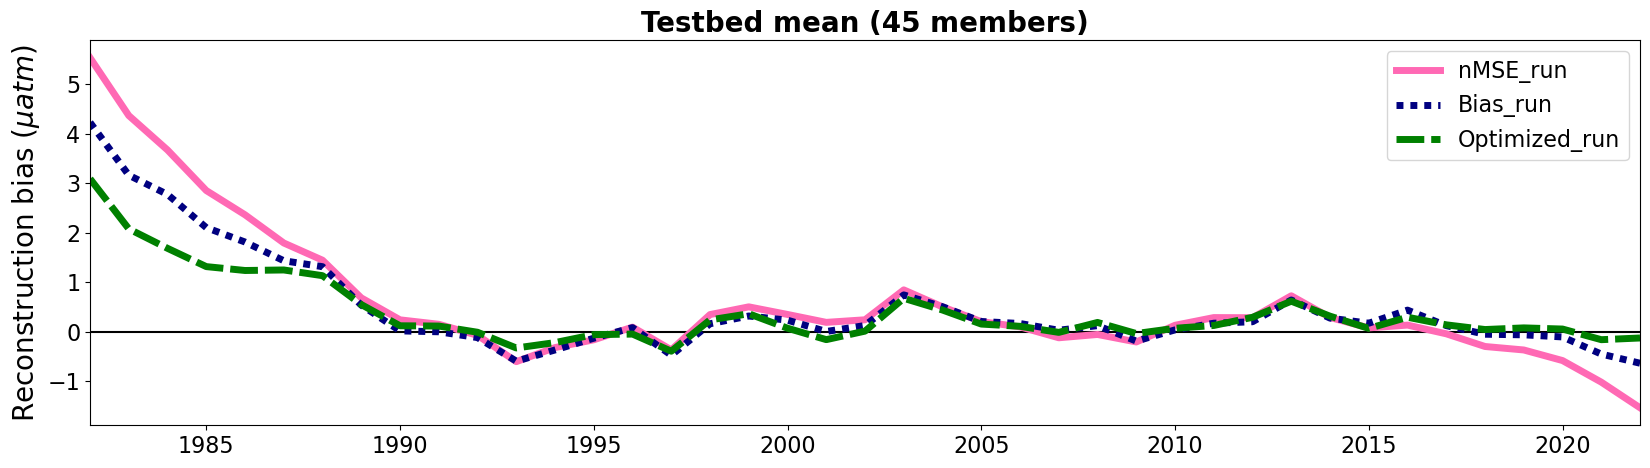

In [9]:
fig = plt.figure(figsize=(20,5))

plt.title('Testbed mean (45 members)', fontsize=20, fontweight="bold")

plt.plot(model_mean_bias_2022_nmse_45.year,testbed_mean_bias_2022_nmse_45,linewidth=5.0,c='hotpink',label='nMSE_run', linestyle='solid')#
plt.plot(model_mean_bias_2022_bias_45.year,testbed_mean_bias_2022_bias_45,linewidth=5.0,c='navy',label='Bias_run', linestyle='dotted', dashes=(1, 1))#
plt.plot(model_mean_bias_2022_opt_45.year,testbed_mean_bias_2022_opt_45,linewidth=5.0,c='green',label='Optimized_run', linestyle='dashed',dashes=(4, 1))#

plt.ylabel('Reconstruction bias ($\mu atm$)', fontsize=20)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.axhline(0,zorder=-10, color='black')
plt.xlim(model_mean_bias_2022_opt_45.year[0],model_mean_bias_2022_opt_45.year[-1]);
plt.legend(fontsize=16);

#fig.savefig("/home/jovyan/timeseries_bias.jpg",dpi=300, bbox_inches="tight")

## Regional biases

### North 

In [22]:
model_mean_biases_2022_opt_45 = []
for model in datasets_ens_2022_opt_45:
    model_mean_bias_2022_opt_45 = model.diff('status').sel(time=slice("1982-01-01",'2022-12-31'), ylat=slice(30,90)).groupby("time.year").mean(['n_member', 'time', 'ylat', 'xlon','status'])
    model_mean_biases_2022_opt_45.append(model_mean_bias_2022_opt_45.values)
testbed_mean_bias_2022_opt_45_north = np.mean(model_mean_biases_2022_opt_45,axis=0)

In [23]:
model_mean_biases_2022_bias_45 = []
for model in datasets_ens_2022_bias_45:
    model_mean_bias_2022_bias_45 = model.diff('status').sel(time=slice("1982-01-01",'2022-12-31'), ylat=slice(30,90)).groupby("time.year").mean(['n_member', 'time', 'ylat', 'xlon','status'])
    model_mean_biases_2022_bias_45.append(model_mean_bias_2022_bias_45.values)
testbed_mean_bias_2022_bias_45_north = np.mean(model_mean_biases_2022_bias_45,axis=0)

In [24]:
model_mean_biases_2022_nmse_45 = []
for model in datasets_ens_2022_nmse_45:
    model_mean_bias_2022_nmse_45 = model.diff('status').sel(time=slice("1982-01-01",'2022-12-31'), ylat=slice(30,90)).groupby("time.year").mean(['n_member', 'time', 'ylat', 'xlon','status'])
    model_mean_biases_2022_nmse_45.append(model_mean_bias_2022_nmse_45.values)
testbed_mean_bias_2022_nmse_45_north = np.mean(model_mean_biases_2022_nmse_45,axis=0)

### Tropics

In [25]:
model_mean_biases_2022_opt_45 = []
for model in datasets_ens_2022_opt_45:
    model_mean_bias_2022_opt_45 = model.diff('status').sel(time=slice("1982-01-01",'2022-12-31'), ylat=slice(-30,30)).groupby("time.year").mean(['n_member', 'time', 'ylat', 'xlon','status'])
    model_mean_biases_2022_opt_45.append(model_mean_bias_2022_opt_45.values)
testbed_mean_bias_2022_opt_45_tropics = np.mean(model_mean_biases_2022_opt_45,axis=0)

In [26]:
model_mean_biases_2022_bias_45 = []
for model in datasets_ens_2022_bias_45:
    model_mean_bias_2022_bias_45 = model.diff('status').sel(time=slice("1982-01-01",'2022-12-31'), ylat=slice(-30,30)).groupby("time.year").mean(['n_member', 'time', 'ylat', 'xlon','status'])
    model_mean_biases_2022_bias_45.append(model_mean_bias_2022_bias_45.values)
testbed_mean_bias_2022_bias_45_tropics = np.mean(model_mean_biases_2022_bias_45,axis=0)

In [27]:
model_mean_biases_2022_nmse_45 = []
for model in datasets_ens_2022_nmse_45:
    model_mean_bias_2022_nmse_45 = model.diff('status').sel(time=slice("1982-01-01",'2022-12-31'), ylat=slice(-30,30)).groupby("time.year").mean(['n_member', 'time', 'ylat', 'xlon','status'])
    model_mean_biases_2022_nmse_45.append(model_mean_bias_2022_nmse_45.values)
testbed_mean_bias_2022_nmse_45_tropics = np.mean(model_mean_biases_2022_nmse_45,axis=0)

### Southern Ocean

In [28]:
model_mean_biases_2022_opt_45 = []
for model in datasets_ens_2022_opt_45:
    model_mean_bias_2022_opt_45 = model.diff('status').sel(time=slice("1982-01-01",'2022-12-31'), ylat=slice(-90,-30)).groupby("time.year").mean(['n_member', 'time', 'ylat', 'xlon','status'])
    model_mean_biases_2022_opt_45.append(model_mean_bias_2022_opt_45.values)
testbed_mean_bias_2022_opt_45_south = np.mean(model_mean_biases_2022_opt_45,axis=0)

In [29]:
model_mean_biases_2022_bias_45 = []
for model in datasets_ens_2022_bias_45:
    model_mean_bias_2022_bias_45 = model.diff('status').sel(time=slice("1982-01-01",'2022-12-31'), ylat=slice(-90,-30)).groupby("time.year").mean(['n_member', 'time', 'ylat', 'xlon','status'])
    model_mean_biases_2022_bias_45.append(model_mean_bias_2022_bias_45.values)
testbed_mean_bias_2022_bias_45_south = np.mean(model_mean_biases_2022_bias_45,axis=0)

In [30]:
model_mean_biases_2022_nmse_45 = []
for model in datasets_ens_2022_nmse_45:
    model_mean_bias_2022_nmse_45 = model.diff('status').sel(time=slice("1982-01-01",'2022-12-31'), ylat=slice(-90,-30)).groupby("time.year").mean(['n_member', 'time', 'ylat', 'xlon','status'])
    model_mean_biases_2022_nmse_45.append(model_mean_bias_2022_nmse_45.values)
testbed_mean_bias_2022_nmse_45_south = np.mean(model_mean_biases_2022_nmse_45,axis=0)

## Figure S1

<>:35: SyntaxWarning: invalid escape sequence '\m'
<>:36: SyntaxWarning: invalid escape sequence '\m'
<>:37: SyntaxWarning: invalid escape sequence '\m'
<>:35: SyntaxWarning: invalid escape sequence '\m'
<>:36: SyntaxWarning: invalid escape sequence '\m'
<>:37: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_15309/2828352513.py:35: SyntaxWarning: invalid escape sequence '\m'
  axs[0].set_ylabel('Reconstruction bias ($\mu$atm)', fontsize=16)
/tmp/ipykernel_15309/2828352513.py:36: SyntaxWarning: invalid escape sequence '\m'
  axs[1].set_ylabel('Reconstruction bias ($\mu$atm)', fontsize=16)
/tmp/ipykernel_15309/2828352513.py:37: SyntaxWarning: invalid escape sequence '\m'
  axs[2].set_ylabel('Reconstruction bias ($\mu$atm)', fontsize=16)


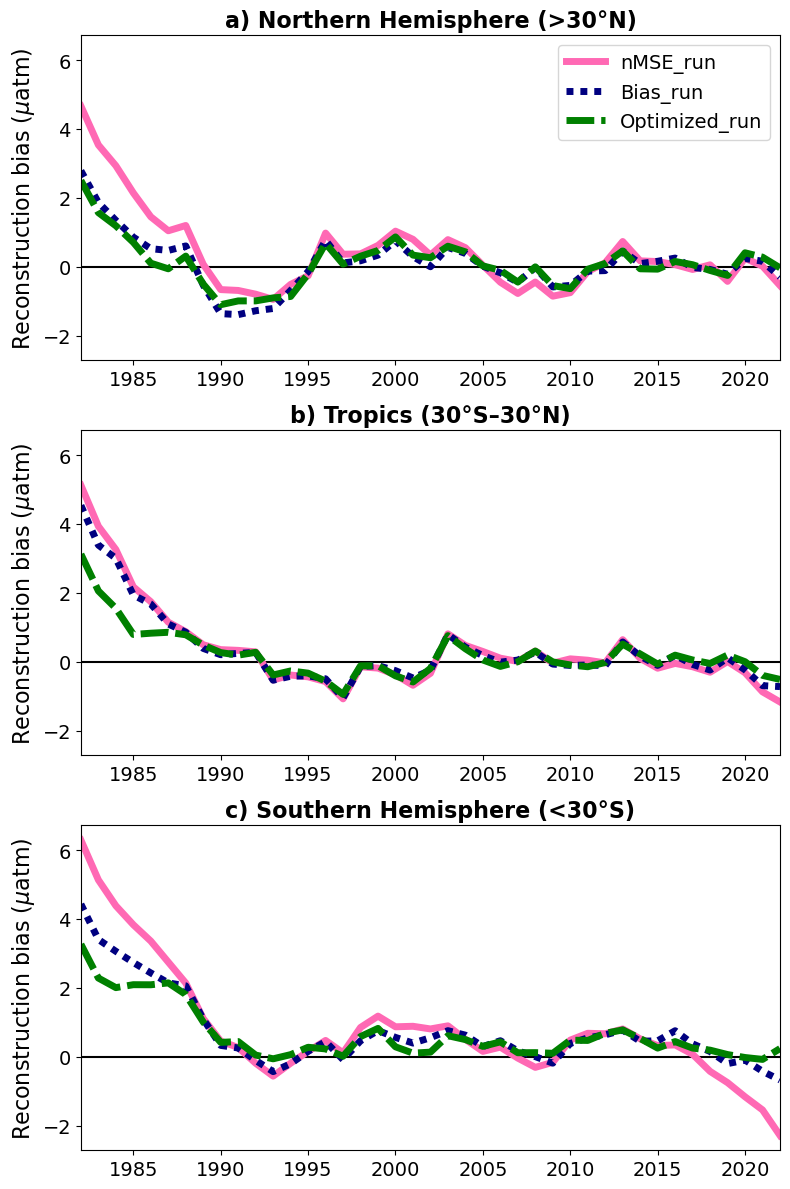

In [31]:
fig, axs = plt.subplots(3, 1, figsize=(8, 12), sharey=True)

regions = ['North', 'Tropics', 'South']
titles = ['a) Northern Hemisphere (>30°N)', 'b) Tropics (30°S–30°N)', 'c) Southern Hemisphere (<30°S)']
suffixes = ['_north', '_tropics', '_south']

for i, (region, title, suffix) in enumerate(zip(regions, titles, suffixes)):
    ax = axs[i]
    
    ax.plot(eval(f"model_mean_bias_2022_nmse_45.year"), 
            eval(f"testbed_mean_bias_2022_nmse_45{suffix}"), 
            linewidth=5.0, c='hotpink', label='nMSE_run', linestyle='solid')

    ax.plot(eval(f"model_mean_bias_2022_bias_45.year"), 
            eval(f"testbed_mean_bias_2022_bias_45{suffix}"), 
            linewidth=5.0, c='navy', label='Bias_run', linestyle='dotted', dashes=(1, 1))

    ax.plot(eval(f"model_mean_bias_2022_opt_45.year"), 
            eval(f"testbed_mean_bias_2022_opt_45{suffix}"), 
            linewidth=5.0, c='green', label='Optimized_run', linestyle='dashed', dashes=(4, 1))
    
    ax.axhline(0, zorder=-10, color='black')
    ax.set_xlim(eval(f"model_mean_bias_2022_opt_45.year[0]"), 
                eval(f"model_mean_bias_2022_opt_45.year[-1]"))

    ax.set_title(title, fontsize=16, fontweight="bold")
    ax.tick_params(labelsize=14)

    # if i == 0:
    #     ax.set_ylabel('Reconstruction bias ($\mu atm$)', fontsize=16)
    # if i == 2:
    #     ax.legend(fontsize=14, loc='upper right')


axs[0].set_ylabel('Reconstruction bias ($\mu$atm)', fontsize=16)
axs[1].set_ylabel('Reconstruction bias ($\mu$atm)', fontsize=16)
axs[2].set_ylabel('Reconstruction bias ($\mu$atm)', fontsize=16)
axs[0].legend(fontsize=14, loc='upper right')

plt.tight_layout()
#fig.savefig("/home/jovyan/timeseries_bias_regions.jpg",dpi=300, bbox_inches="tight")

## Figure 1

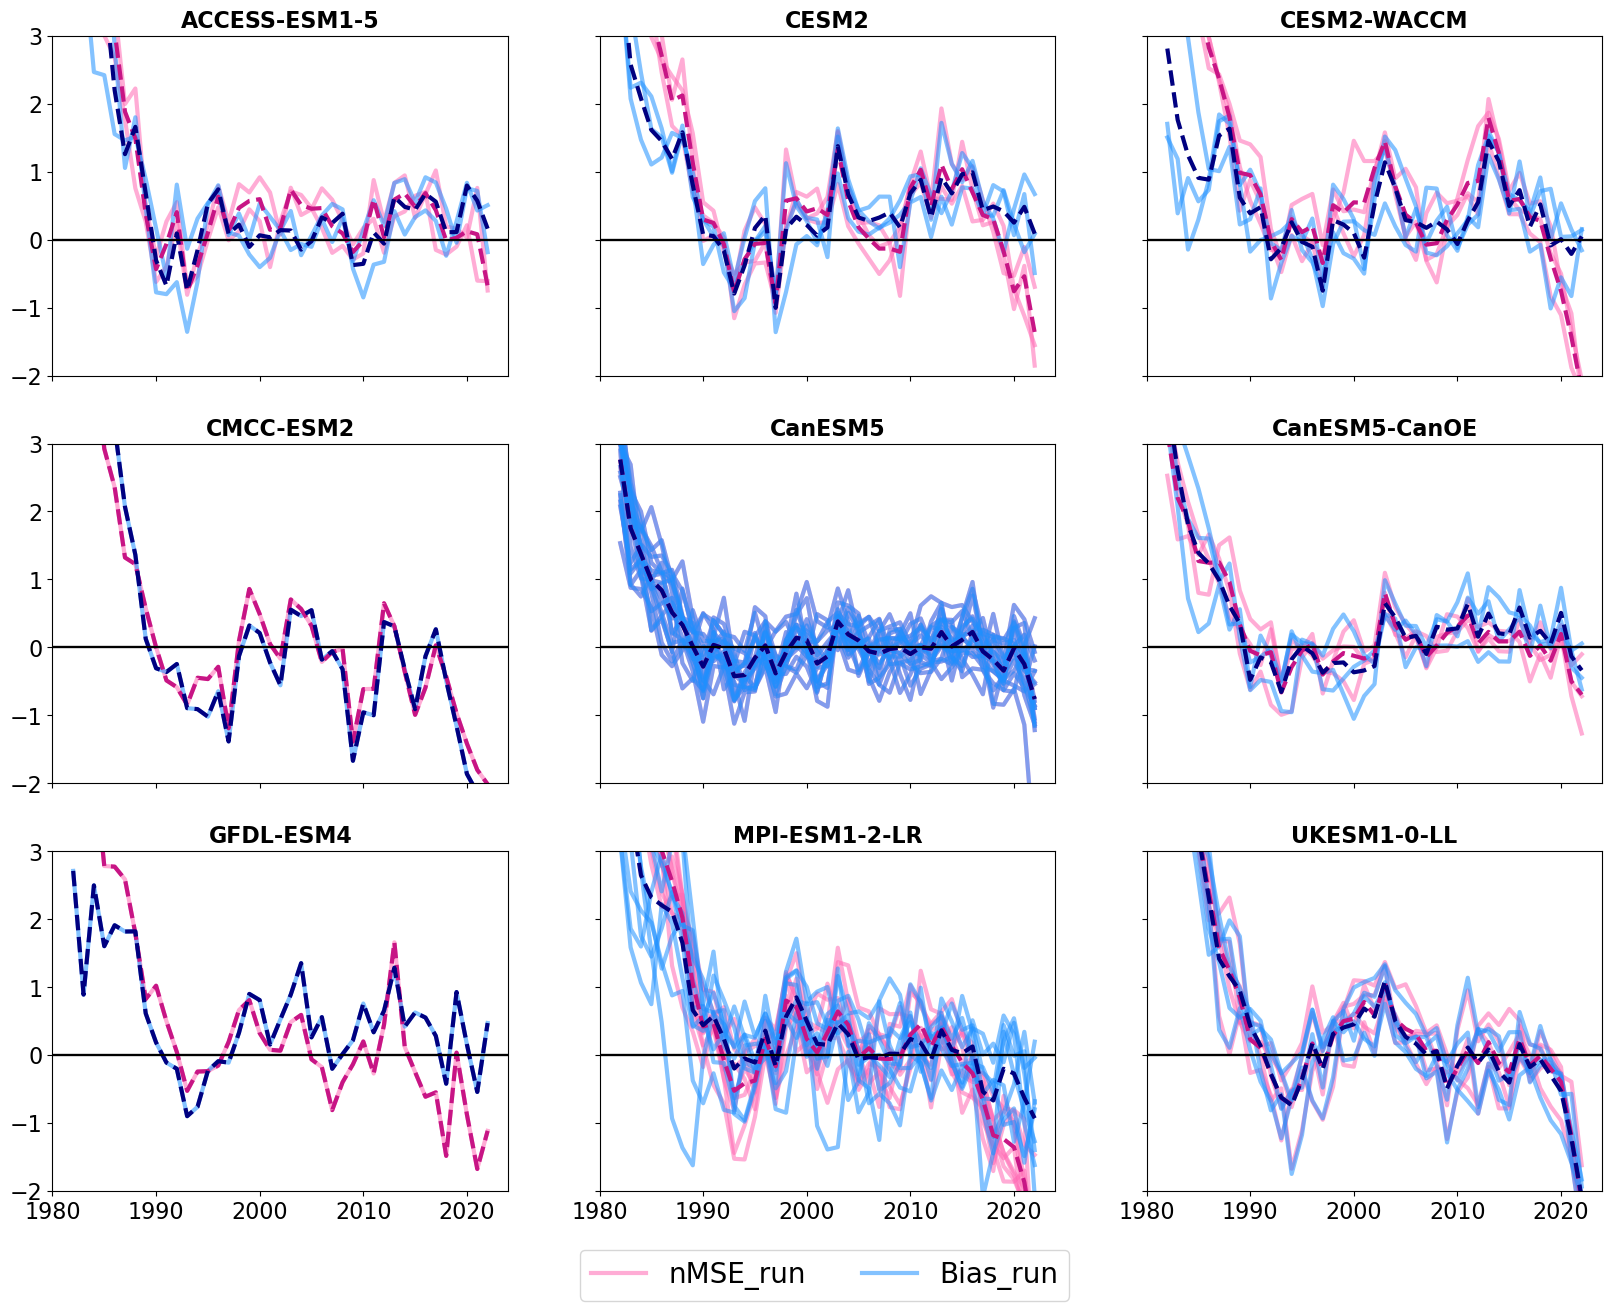

In [10]:
fig, axs = plt.subplots(3,3,figsize=(20,15), sharex=True, sharey=True) 

for i, ax in enumerate(fig.axes):
    bias_nmse = datasets_ens_2022_nmse_45[i].diff('status').sel(time=slice("1982-02-01","2022-12-31")).groupby("time.year").mean(['time', 'ylat', 'xlon','status'])
    ax.set_title(bias_nmse.ensemble.values,fontsize=16, fontweight="bold")
    for mem_bias_nmse in bias_nmse:
        ax.plot(bias_nmse.year, mem_bias_nmse, linewidth=3.0, color ='hotpink', alpha=.55, label='nMSE_run')
    ax.axhline(0, color='black')
    ax.set_ylim(-2, 3)
    ax.yaxis.set_tick_params(labelsize=16)
    ax.xaxis.set_tick_params(labelsize=16)

for i, ax in enumerate(fig.axes):
    bias = datasets_ens_2022_bias_45[i].diff('status').sel(time=slice("1982-02-01","2022-12-31")).groupby("time.year").mean(['time', 'ylat', 'xlon','status'])
    ax.set_title(bias.ensemble.values,fontsize=16, fontweight="bold")
    for mem_bias in bias:
        ax.plot(bias.year, mem_bias, linewidth=3.0, color ='dodgerblue', linestyle='solid', alpha=.55, label='Bias_run')
    ax.axhline(0, color='black')
    ax.set_ylim(-2, 3)
    ax.yaxis.set_tick_params(labelsize=16)
    ax.xaxis.set_tick_params(labelsize=16)

for i, ax in enumerate(fig.axes):
    bias = datasets_ens_2022_nmse_45[i].diff('status').sel(time=slice("1982-02-01","2022-12-31")).groupby("time.year").mean(['time', 'ylat', 'xlon','status','n_member'])
    ax.set_title(bias.ensemble.values,fontsize=16, fontweight="bold")
    ax.plot(bias.year, bias, linewidth=3.0, color ='mediumvioletred', linestyle='dashed')
    ax.axhline(0, color='black')
    ax.set_ylim(-2, 3)
    ax.yaxis.set_tick_params(labelsize=16)
    ax.xaxis.set_tick_params(labelsize=16)

for i, ax in enumerate(fig.axes):
    bias = datasets_ens_2022_bias_45[i].diff('status').sel(time=slice("1982-02-01","2022-12-31")).groupby("time.year").mean(['time', 'ylat', 'xlon','status','n_member'])
    ax.set_title(bias.ensemble.values,fontsize=16, fontweight="bold")
    ax.plot(bias.year, bias, linewidth=3.0, color ='navy', linestyle='dashed')
    ax.axhline(0, color='black')
    ax.set_ylim(-2, 3)
    ax.yaxis.set_tick_params(labelsize=16)
    ax.xaxis.set_tick_params(labelsize=16)


handles, labels = ax.get_legend_handles_labels()
handle_list, label_list = [], []
for handle, label in zip(handles, labels):
    if label not in label_list:
        handle_list.append(handle)
        label_list.append(label)
fig.legend(handle_list, label_list, loc='upper center', bbox_to_anchor=(0.511, 0.08), ncol=2, fontsize=20);
#fig.savefig("/home/jovyan/timeseries_bias_ESM.jpg",dpi=300, bbox_inches="tight")

## Figure S8

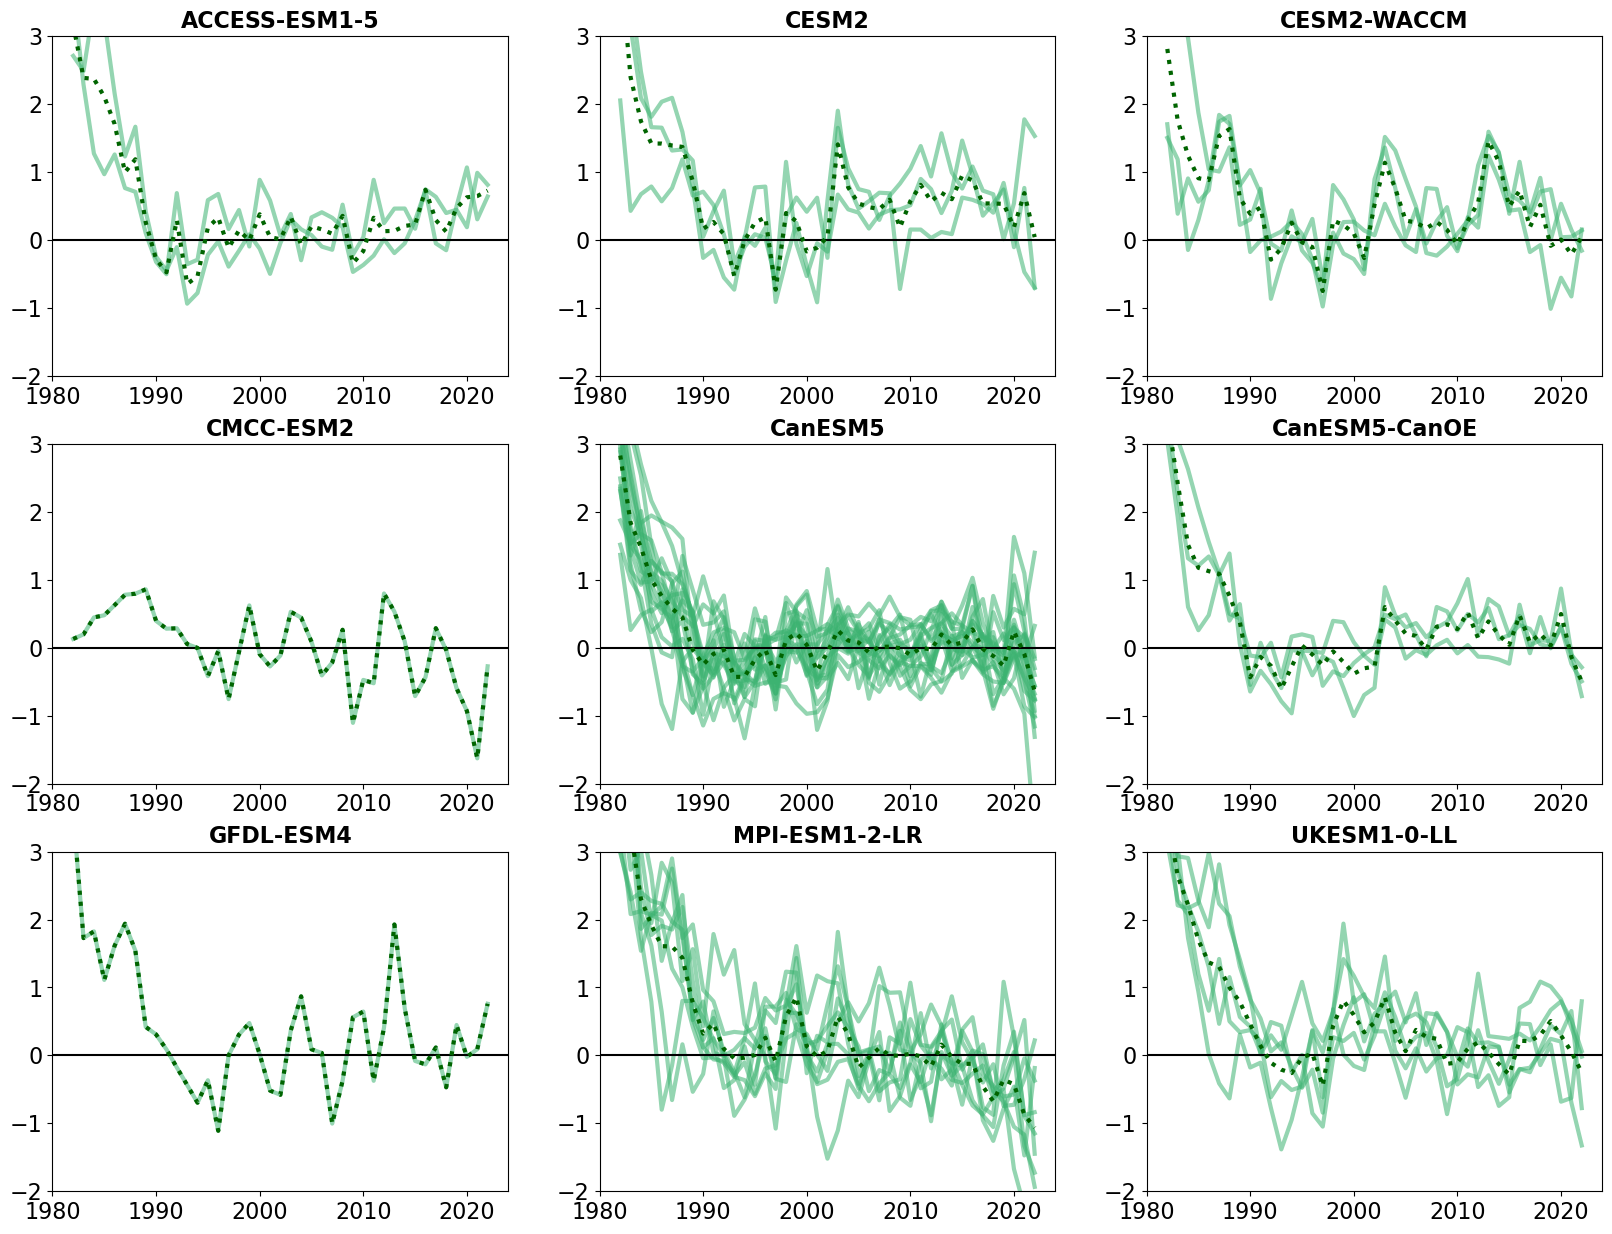

In [11]:
fig, axs = plt.subplots(3,3,figsize=(20,15)) 

for i, ax in enumerate(fig.axes):
    bias = datasets_ens_2022_opt_45[i].diff('status').sel(time=slice("1982-02-01","2022-12-31")).groupby("time.year").mean(['time', 'ylat', 'xlon','status'])
    ax.set_title(bias.ensemble.values,fontsize=16, fontweight="bold")
    for mem_bias in bias:
        ax.plot(bias.year, mem_bias, linewidth=3.0, color ='mediumseagreen', alpha=.55, label='Optimized_run')
    ax.axhline(0, color='black')
    ax.yaxis.set_tick_params(labelsize=16)
    ax.xaxis.set_tick_params(labelsize=16)

for i, ax in enumerate(fig.axes):
    bias = datasets_ens_2022_opt_45[i].diff('status').sel(time=slice("1982-02-01","2022-12-31")).groupby("time.year").mean(['time', 'ylat', 'xlon','status','n_member'])
    ax.set_title(bias.ensemble.values,fontsize=16, fontweight="bold")
    ax.plot(bias.year, bias, linewidth=3.0, color ='darkgreen', linestyle='dotted')
    ax.set_ylim(-2, 3)
    ax.yaxis.set_tick_params(labelsize=16)
    ax.xaxis.set_tick_params(labelsize=16)

#fig.savefig("/home/jovyan/timeseries_bias_optimized.jpg",dpi=300, bbox_inches="tight")

### Figure S7

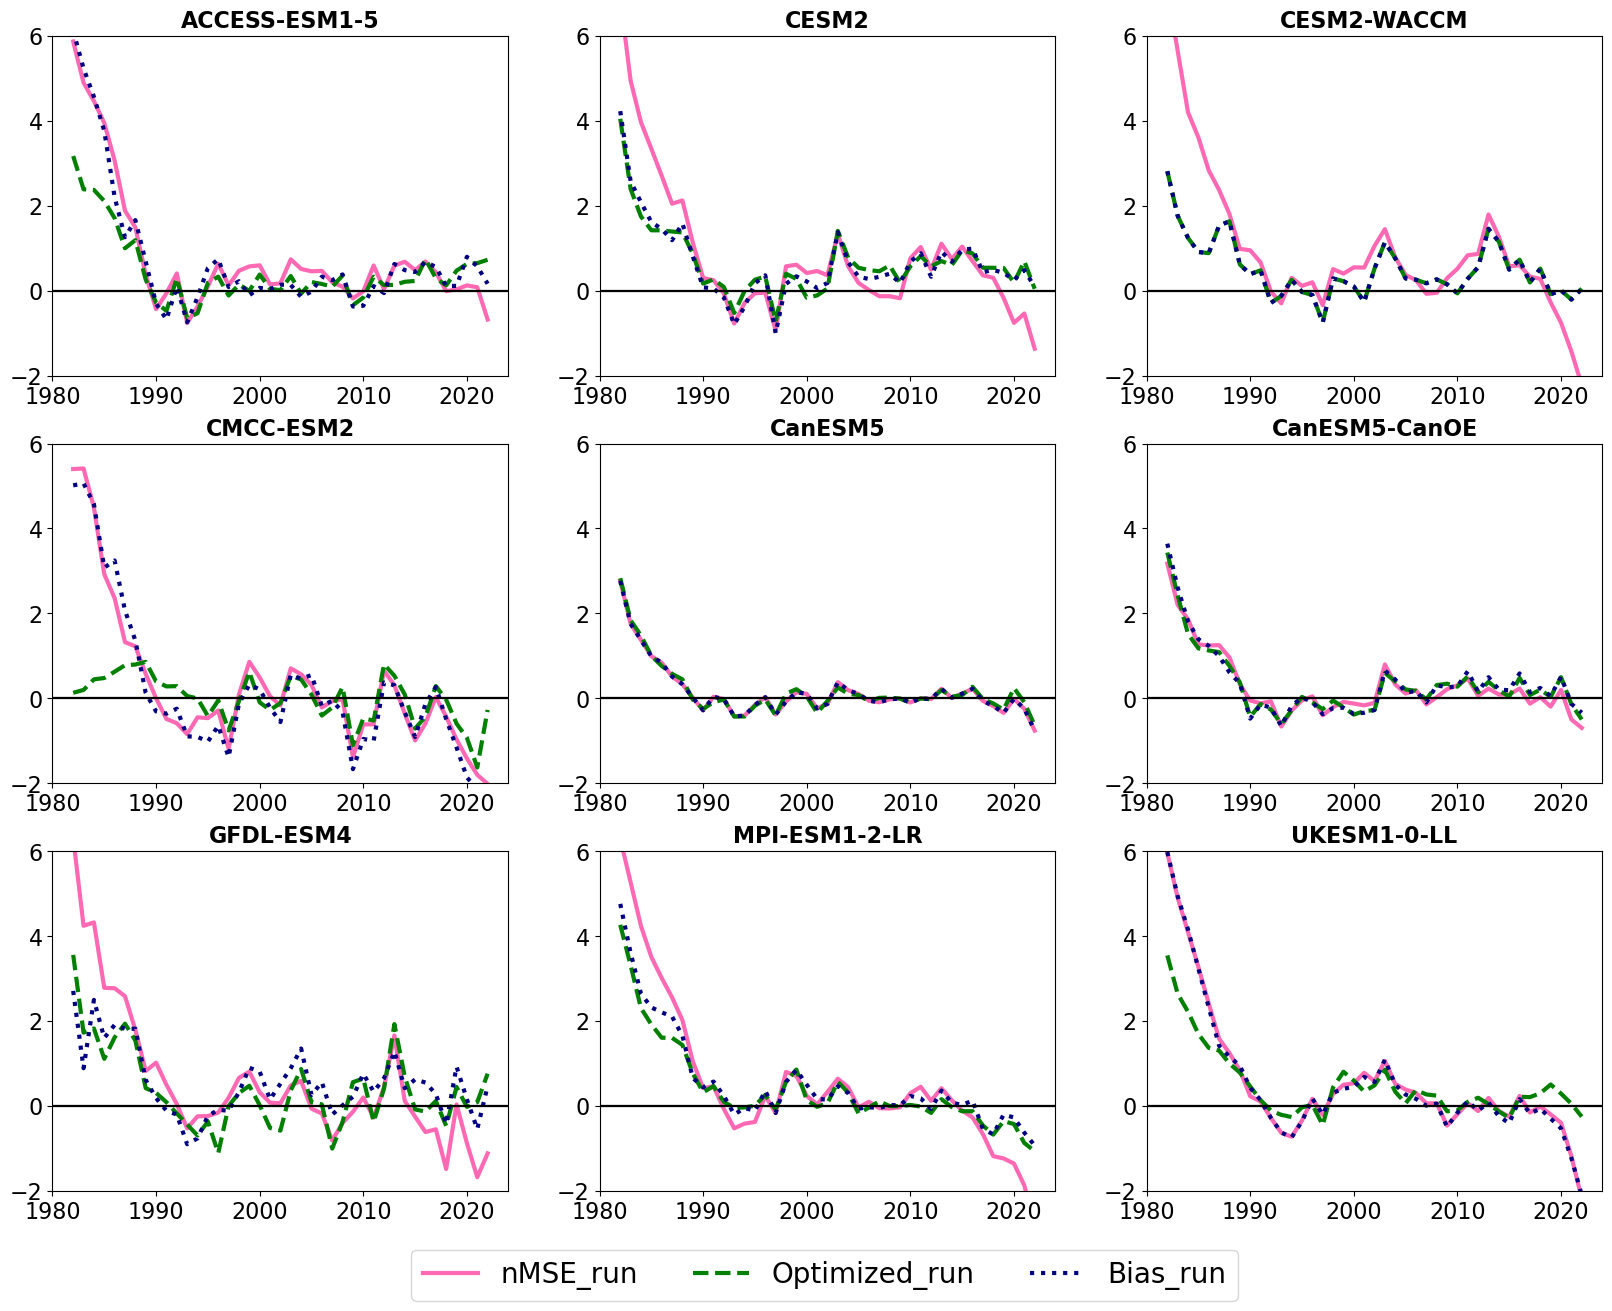

In [12]:
fig, axs = plt.subplots(3,3,figsize=(20,15))

for i, ax in enumerate(fig.axes):
    bias = datasets_ens_2022_nmse_45[i].diff('status').sel(time=slice("1982-02-01","2022-12-31")).groupby("time.year").mean(['time', 'ylat', 'xlon','status','n_member'])
    ax.set_title(bias.ensemble.values,fontsize=16, fontweight="bold")
    ax.plot(bias.year, bias, linewidth=3.0, color ='hotpink', linestyle='solid', label='nMSE_run')
    ax.axhline(0, color='black')
    ax.set_ylim(-2, 6)
    ax.yaxis.set_tick_params(labelsize=16)
    ax.xaxis.set_tick_params(labelsize=16)

for i, ax in enumerate(fig.axes):
    bias = datasets_ens_2022_opt_45[i].diff('status').sel(time=slice("1982-02-01","2022-12-31")).groupby("time.year").mean(['time', 'ylat', 'xlon','status','n_member'])
    ax.set_title(bias.ensemble.values,fontsize=16, fontweight="bold")
    ax.plot(bias.year, bias, linewidth=3.0, color ='green', linestyle='dashed', label='Optimized_run')
    ax.axhline(0, color='black')
    ax.set_ylim(-2, 6)
    ax.yaxis.set_tick_params(labelsize=16)
    ax.xaxis.set_tick_params(labelsize=16)

for i, ax in enumerate(fig.axes):
    bias = datasets_ens_2022_bias_45[i].diff('status').sel(time=slice("1982-02-01","2022-12-31")).groupby("time.year").mean(['time', 'ylat', 'xlon','status','n_member'])
    ax.set_title(bias.ensemble.values,fontsize=16, fontweight="bold")
    ax.plot(bias.year, bias, linewidth=3.0, color ='navy', linestyle='dotted', label='Bias_run')
    ax.axhline(0, color='black')
    ax.set_ylim(-2, 6)
    ax.yaxis.set_tick_params(labelsize=16)
    ax.xaxis.set_tick_params(labelsize=16)
    
handles, labels = ax.get_legend_handles_labels()
handle_list, label_list = [], []
for handle, label in zip(handles, labels):
    if label not in label_list:
        handle_list.append(handle)
        label_list.append(label)
fig.legend(handle_list, label_list, loc='upper center', bbox_to_anchor=(0.511, 0.08), ncol=3, fontsize=20);

#fig.savefig("/home/jovyan/timeseries_ESM.jpg",dpi=300, bbox_inches="tight")

## Figure S2

In [14]:
model_mean_biases_2022_opt_45 = []
for model in datasets_ens_2022_opt_45:
    model_mean_bias_2022_opt_45 = model.diff('status').sel(time=slice("2020-01-01",'2022-12-31')).mean(['n_member', 'time', 'status'])
    model_mean_biases_2022_opt_45.append(model_mean_bias_2022_opt_45)
all_ens = xr.concat(model_mean_biases_2022_opt_45, dim='ensemble', join='override') 
testbed_mean_bias_2022_opt_45 = all_ens.mean(dim='ensemble').drop_vars('member')

In [38]:
print(np.nanmean(testbed_mean_bias_2022_opt_45))

-0.08120151292792224


In [15]:
model_mean_biases_2022_nmse_45 = []
for model in datasets_ens_2022_nmse_45:
    model_mean_bias_2022_nmse_45 = model.diff('status').sel(time=slice("2020-01-01",'2022-12-31')).mean(['n_member', 'time', 'status'])
    model_mean_biases_2022_nmse_45.append(model_mean_bias_2022_nmse_45)
all_ens = xr.concat(model_mean_biases_2022_nmse_45, dim='ensemble', join='override') 
testbed_mean_bias_2022_nmse_45 = all_ens.mean(dim='ensemble').drop_vars('member')

In [16]:
print(np.nanmean(testbed_mean_bias_2022_nmse_45))

-1.041498265754994


In [17]:
model_mean_biases_2022_bias_45 = []
for model in datasets_ens_2022_bias_45:
    model_mean_bias_2022_bias_45 = model.diff('status').sel(time=slice("2020-01-01",'2022-12-31')).mean(['n_member', 'time', 'status'])
    model_mean_biases_2022_bias_45.append(model_mean_bias_2022_bias_45)
all_ens = xr.concat(model_mean_biases_2022_bias_45, dim='ensemble', join='override') 
testbed_mean_bias_2022_bias_45 = all_ens.mean(dim='ensemble').drop_vars('member')

In [31]:
print(np.nanmean(testbed_mean_bias_2022_bias_45))

-0.3996659851656736


<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_15309/3286361342.py:4: SyntaxWarning: invalid escape sequence '\m'
  lab = f'Mean bias 2020-2022 ($\mu atm$)'
/srv/conda/envs/notebook/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:394: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


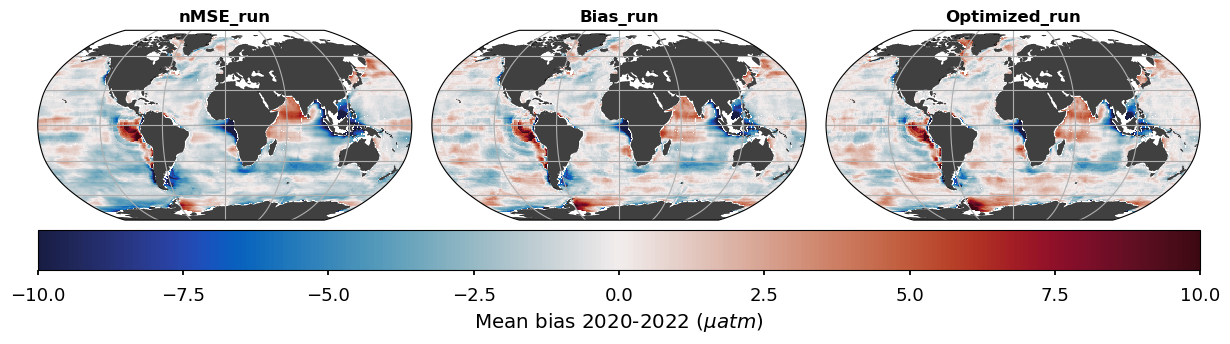

In [21]:
vrange = [-10, 10, 1]
fig_shape = (1,3)
cmap = cmocean.cm.balance
lab = f'Mean bias 2020-2022 ($\mu atm$)'
   
      
with plt.style.context('seaborn-v0_8-talk'):
    fig = plt.figure(figsize=(15,5))

    dia = SpatialMap2(nrows_ncols=fig_shape, fig=fig, cbar_location='bottom', cbar_orientation='horizontal')
    
    sub = dia.add_plot(lat = testbed_mean_bias_2022_nmse_45['ylat'], 
                           lon = testbed_mean_bias_2022_nmse_45['xlon'], 
                           data = testbed_mean_bias_2022_nmse_45, 
                           vrange=vrange[0:2],
                           cmap=cmap, 
                           ax=0)

    dia.set_title("nMSE_run", 0, loc="center",fontsize=12, fontweight='bold')

    sub = dia.add_plot(lat = testbed_mean_bias_2022_bias_45['ylat'], 
                           lon = testbed_mean_bias_2022_bias_45['xlon'], 
                           data = testbed_mean_bias_2022_bias_45, 
                           vrange=vrange[0:2],
                           cmap=cmap, 
                           ax=1)

    dia.set_title("Bias_run", 1, loc="center",fontsize=12, fontweight='bold')

    sub = dia.add_plot(lat = testbed_mean_bias_2022_opt_45['ylat'], 
                           lon = testbed_mean_bias_2022_opt_45['xlon'], 
                           data = testbed_mean_bias_2022_opt_45, 
                           vrange=vrange[0:2],
                           cmap=cmap, 
                           ax=2)

    dia.set_title("Optimized_run", 2, loc="center",fontsize=12, fontweight='bold')

    col = dia.add_colorbar(sub)
    dia.set_cbar_xlabel(col, lab)
    
    dia.grid[0].gridlines(draw_labels=False)
    dia.grid[1].gridlines(draw_labels=False)
    dia.grid[2].gridlines(draw_labels=False)

#fig.savefig("/home/jovyan/bias_2020-2022.jpg",dpi=300, bbox_inches="tight")

## Reconstruction RMSE

### Figure 2

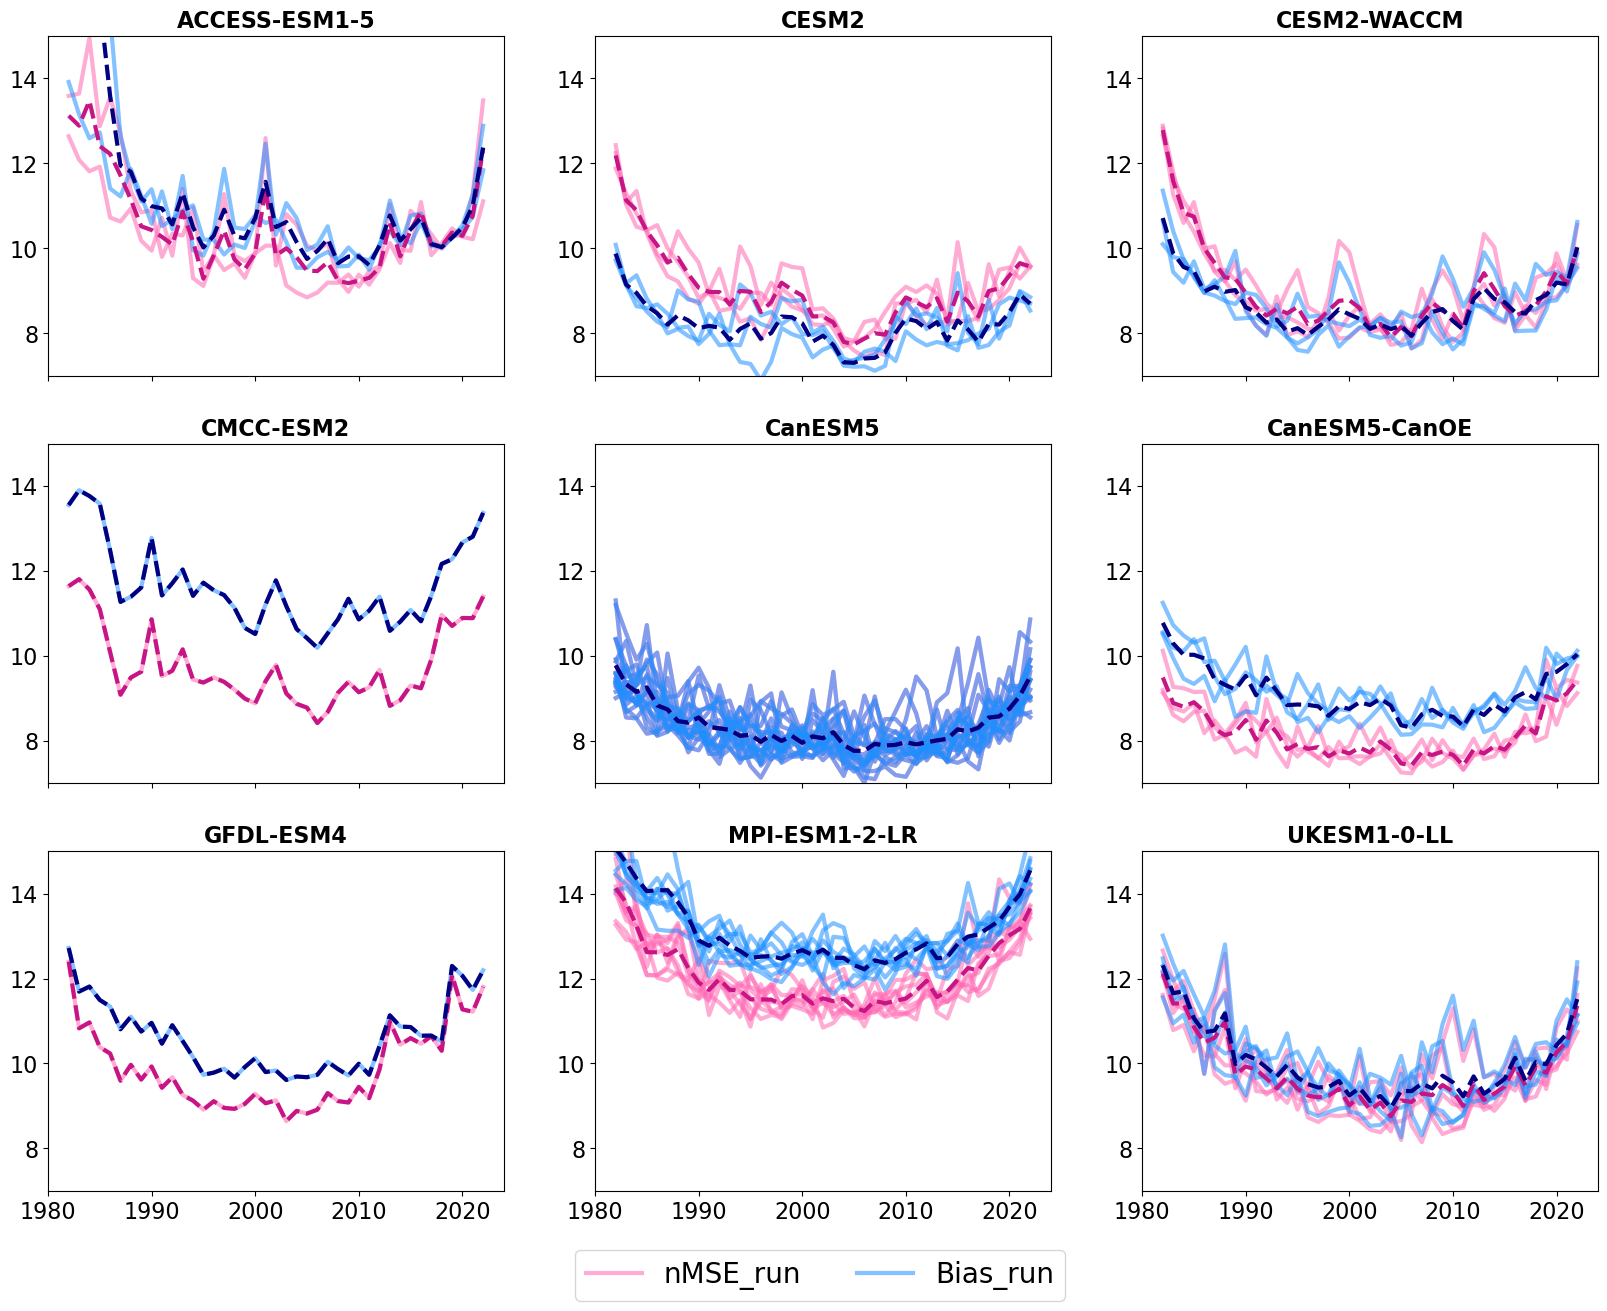

In [13]:
fig, axs = plt.subplots(3,3,figsize=(20,15), sharex=True)#, sharey=True) 


for i, ax in enumerate(fig.axes):
    nmse = np.sqrt(((datasets_ens_2022_nmse_45[i].diff('status'))**2).sel(time=slice('1982-02-01','2022-12-31')).groupby("time.year").mean(['time', 'ylat', 'xlon','status']))
    ax.set_title(nmse.ensemble.values,fontsize=16, fontweight="bold")
    for ii, mem_nmse in enumerate(nmse):
        ax.plot(nmse.year, mem_nmse, linewidth=3.0, color ='hotpink', alpha=.55,label='nMSE_run')
    ax.set_ylim(7, 15)
    ax.yaxis.set_tick_params(labelsize=16)
    ax.xaxis.set_tick_params(labelsize=16)

for i, ax in enumerate(fig.axes):
    nmse = np.sqrt(((datasets_ens_2022_bias_45[i].diff('status'))**2).sel(time=slice('1982-02-01','2022-12-31')).groupby("time.year").mean(['time', 'ylat', 'xlon','status']))
    ax.set_title(nmse.ensemble.values,fontsize=16, fontweight="bold")
    for ii, mem_nmse in enumerate(nmse):
        ax.plot(nmse.year, mem_nmse, linewidth=3.0, color ='dodgerblue', alpha=.55,label='Bias_run')
    ax.set_ylim(7, 15)
    ax.yaxis.set_tick_params(labelsize=16)
    ax.xaxis.set_tick_params(labelsize=16)


for i, ax in enumerate(fig.axes):
    nmse = np.sqrt(((datasets_ens_2022_nmse_45[i].diff('status'))**2).sel(time=slice('1982-02-01','2022-12-31')).groupby("time.year").mean(['time', 'ylat', 'xlon','status','n_member']))
    ax.set_title(nmse.ensemble.values,fontsize=16, fontweight="bold")
    ax.plot(nmse.year, nmse, linewidth=3.0, color ='mediumvioletred', linestyle='dashed')
    ax.set_ylim(7, 15)
    ax.yaxis.set_tick_params(labelsize=16)
    ax.xaxis.set_tick_params(labelsize=16)

for i, ax in enumerate(fig.axes):
    nmse = np.sqrt(((datasets_ens_2022_bias_45[i].diff('status'))**2).sel(time=slice('1982-02-01','2022-12-31')).groupby("time.year").mean(['time', 'ylat', 'xlon','status','n_member']))
    ax.set_title(nmse.ensemble.values,fontsize=16, fontweight="bold")
    ax.plot(nmse.year, nmse, linewidth=3.0, color ='navy', linestyle='dashed')
    ax.set_ylim(7, 15)
    ax.yaxis.set_tick_params(labelsize=16)
    ax.xaxis.set_tick_params(labelsize=16)

handles, labels = ax.get_legend_handles_labels()
handle_list, label_list = [], []
for handle, label in zip(handles, labels):
    if label not in label_list:
        handle_list.append(handle)
        label_list.append(label)
fig.legend(handle_list, label_list, loc='upper center', bbox_to_anchor=(0.511, 0.08), ncol=2, fontsize=20)

#fig.savefig("/home/jovyan/timeseries_RMSE.jpg",dpi=300, bbox_inches="tight")

### Table 5 and S1: Mean RMSE/bias for specific time periods

### RMSE

#### nMSE_Run

In [17]:
model_mean_rmses_2022_nmse_45 = []
for model in datasets_ens_2022_nmse_45:
    model_mean_rmse_2022_nmse_45 = np.sqrt(((model.diff('status'))**2).sel(time=slice('2017-01-01','2022-12-31')).mean(['n_member', 'time', 'ylat', 'xlon','status']))
    model_mean_rmses_2022_nmse_45.append(model_mean_rmse_2022_nmse_45.values)
testbed_mean_rmse_2022_nmse_45 = model_mean_rmses_2022_nmse_45

In [18]:
testbed_mean_rmse_2022_nmse_45

[array(10.68572648),
 array(9.18087434),
 array(9.1506655),
 array(10.80526505),
 array(8.80454243),
 array(8.85787765),
 array(11.23880442),
 array(12.91191799),
 array(10.2384179)]

In [19]:
print(np.nanmean(testbed_mean_rmse_2022_nmse_45))

10.208232417217003


#### Optimized_Run

In [11]:
model_mean_rmses_2022_opt_45 = []
for model in datasets_ens_2022_opt_45:
    model_mean_rmse_2022_opt_45 = np.sqrt(((model.diff('status'))**2).sel(time=slice('2017-01-01','2022-12-31')).mean(['n_member', 'time', 'ylat', 'xlon','status']))
    model_mean_rmses_2022_opt_45.append(model_mean_rmse_2022_opt_45.values)
testbed_mean_rmse_2022_opt_45 = model_mean_rmses_2022_opt_45

In [12]:
testbed_mean_rmse_2022_opt_45

[array(10.36026306),
 array(8.97056833),
 array(9.09726196),
 array(10.63700853),
 array(9.28282239),
 array(9.29362633),
 array(10.90990835),
 array(13.01173229),
 array(10.09796554)]

In [13]:
print(np.nanmean(testbed_mean_rmse_2022_opt_45))

10.184572975405336


### BIAS

#### nMSE_Run

In [25]:
model_mean_biases_2022_nmse = []
for model in datasets_ens_2022_nmse_45:
    model_mean_bias_2022_nmse = model.diff('status').sel(time=slice("2017-01-01",'2022-12-31')).mean(['n_member', 'time', 'ylat', 'xlon','status'])
    model_mean_biases_2022_nmse.append(model_mean_bias_2022_nmse.values)
testbed_mean_bias_2022_nmse = model_mean_biases_2022_nmse

In [26]:
testbed_mean_bias_2022_nmse

[array(-0.00521256),
 array(-0.36450689),
 array(-0.68435127),
 array(-1.1045402),
 array(-0.26852573),
 array(-0.21629766),
 array(-0.94639567),
 array(-1.52082108),
 array(-0.69108506)]

In [27]:
print(np.nanmean(testbed_mean_bias_2022_nmse))

-0.6446373460100396


#### Optimized_Run

In [21]:
model_mean_biases_2022_opt = []
for model in datasets_ens_2022_opt_45:
    model_mean_bias_2022_opt = model.diff('status').sel(time=slice("2017-01-01",'2022-12-31')).mean(['n_member', 'time', 'ylat', 'xlon','status'])
    model_mean_biases_2022_opt.append(model_mean_bias_2022_opt.values)
testbed_mean_bias_2022_opt = model_mean_biases_2022_opt

In [22]:
testbed_mean_bias_2022_opt

[array(0.48381676),
 array(0.42202542),
 array(0.07856906),
 array(-0.53083911),
 array(-0.1504181),
 array(0.02859529),
 array(0.15480304),
 array(-0.64304337),
 array(0.18321065)]

In [23]:
print(np.nanmean(testbed_mean_bias_2022_opt))

0.0029688498655930807
